In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [9]:
# Data Preprocessing
data_trail1 = pd.read_csv("Trail1_extracted_features_acceleration_m1ai1-2.csv")
data_trail2 = pd.read_csv("Trail2_extracted_features_acceleration_m1ai1-1.csv")
data_trail3 = pd.read_csv("Trail3_extracted_features_acceleration_m2ai0-1.csv")

df  = pd.concat([data_trail1,data_trail2,data_trail3], ignore_index=True)

df.drop(columns=["start_time", "axle", "cluster", "tsne_1", "tsne_2",], inplace=True)

df["event"] = df["event"].apply(lambda x : 0 if x == "normal" else 1)

In [10]:
# Data Transformation

#drop event cause I don't want to normalize 0 and 1
x = df.drop(columns="event").values

#using the scaler normalizer
normalizer = preprocessing.Normalizer().fit(x)
norm_x = normalizer.transform(x)

#using the scaler minmax
minmax = preprocessing.MinMaxScaler().fit(x)
minmax_x = minmax.transform(x)

#create the dataframe again with normalized values
df_norm = pd.DataFrame(norm_x, columns=df.drop(columns="event").columns)
#df for minmax
df_minmax = pd.DataFrame(minmax_x, columns=df.drop(columns="event").columns)

#add the dropped event values
df_norm["event"] = df["event"].values
df_minmax["event"] = df["event"].values


df_norm.to_csv('preprocessed_data_norm.csv', index=False)
df_minmax.to_csv('preprocessed_data_minmax.csv', index=False)
#print(df_norm)
#print(df_minmax)

print(df["event"].value_counts())

event
1    90
0    60
Name: count, dtype: int64


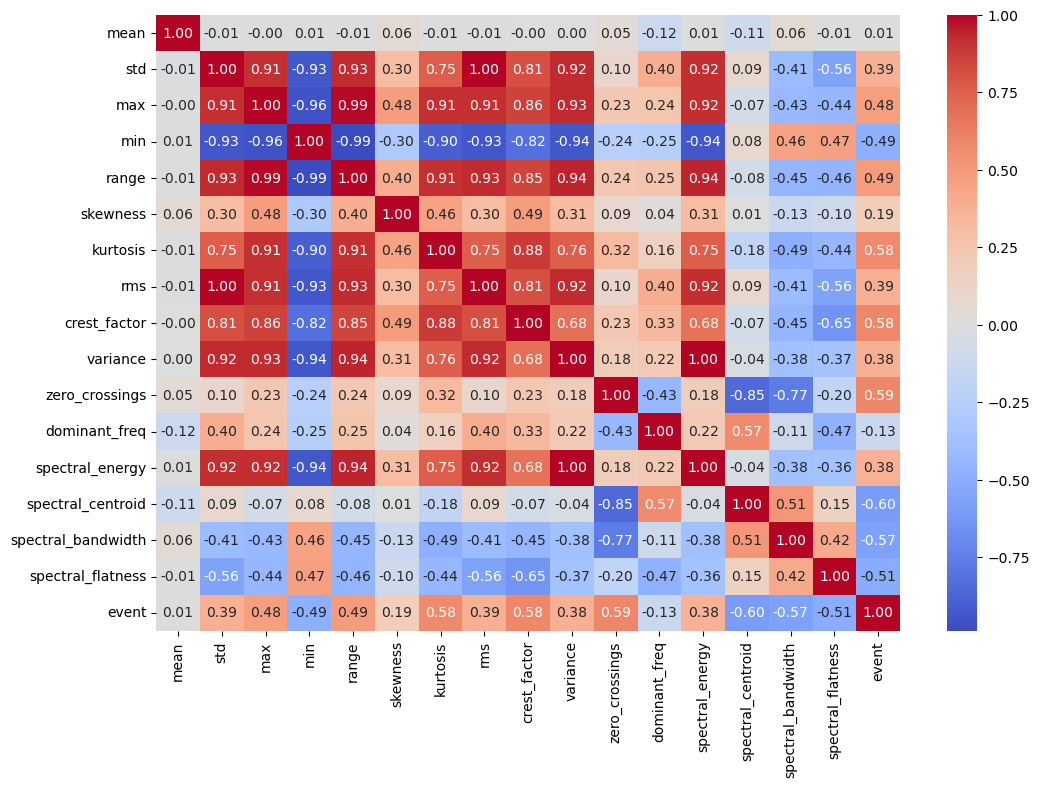

In [11]:
import seaborn as sns

# pearson correlation to identify features to prioritize
corr_matrix = df_norm.corr()

# heatmap of cm
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [12]:
# Dataset Splitting
from sklearn.model_selection import train_test_split

#One for Normalized data /w low correlation features removed
X_norm = df_norm.drop(columns=["event", "mean", "skewness", "dominant_freq"])
Y_norm = df_norm["event"]

#One for MinMax Scaled Data
X_mm = df_minmax.drop(columns=["event"])
Y_mm = df_minmax["event"]

Xn_train, Xn_test, Yn_train, Yn_test = train_test_split(X_norm, Y_norm, test_size=0.2, train_size=0.8, random_state=42)
Xm_train, Xm_test, Ym_train, Ym_test = train_test_split(X_mm, Y_mm, test_size=0.2, train_size=0.8, random_state=42)

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import  precision_score, recall_score, f1_score

#Normalizer
model_norm = SVC()
model_norm.fit(Xn_train, Yn_train)

#Minmax Scaler
model_mm = SVC()
model_mm.fit(Xm_train, Ym_train)

#Normalizer
prediction_Yn = model_norm.predict(Xn_test)
#Minmax Scaler
prediction_Ym = model_mm.predict(Xm_test)

#Normalizer
precision_norm = precision_score(Yn_test, prediction_Yn)
recall_norm = recall_score(Yn_test, prediction_Yn)
f1_norm = f1_score(Yn_test, prediction_Yn)

#Minmax Scaler
precision_mm = precision_score(Ym_test, prediction_Ym)
recall_mm = recall_score(Ym_test, prediction_Ym)
f1_mm = f1_score(Ym_test, prediction_Ym)

print(f"Precision (Normalizer): {precision_norm:.4f}")
print(f"Recall (Normalizer): {recall_norm:.4f}")
print(f"F1-Score (Normalizer): {f1_norm:.4f}")
print(f"Precision (MinMax): {precision_mm:.4f}")
print(f"Recall (MinMax): {recall_mm:.4f}")
print(f"F1-Score (MinMax): {f1_mm:.4f}")

Precision (Normalizer): 0.9565
Recall (Normalizer): 0.9565
F1-Score (Normalizer): 0.9565
Precision (MinMax): 1.0000
Recall (MinMax): 0.9565
F1-Score (MinMax): 0.9778


In [14]:
from sklearn.metrics import confusion_matrix
#added a confusion matrix to analyze how the model performed in the specific predictions.
cm_norm = confusion_matrix(Yn_test, prediction_Yn)
cm_mm = confusion_matrix(Ym_test, prediction_Ym)
print("(Normalizer)", cm_norm)
print("(MinMax)", cm_mm)

(Normalizer) [[ 6  1]
 [ 1 22]]
(MinMax) [[ 7  0]
 [ 1 22]]


1. Feature extraction: In order to indicate events successfully, it is important to first identify key attributes that correlates to these events.
2. Data preprocessing: To get the most realiable model the data needs to be inspected and cleaned. This is done by handling missing values and outliers. Normalizing the data is also common for different things but one is to scale the features to a similar range which gives all the features the same "chance".
3. Selection of Model: What type of method benefits the specific goal in mind.
4. Train: The model algorithm is then ready to be fitted to the training dataset.
5. Eval: What type of performance metrics give the best and clear representation of how well it did the job? In this case RECALL is probably very important to identify how often the model missed and event which could cause great damage.